<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#feature-scaling" data-toc-modified-id="feature-scaling-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>feature scaling</a></span></li><li><span><a href="#feature-extraction-from-lstm" data-toc-modified-id="feature-extraction-from-lstm-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>feature extraction from lstm</a></span></li></ul></li><li><span><a href="#LDA" data-toc-modified-id="LDA-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>LDA</a></span><ul class="toc-item"><li><span><a href="#catboost" data-toc-modified-id="catboost-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>catboost</a></span></li><li><span><a href="#CatBoost-Cross-Validation" data-toc-modified-id="CatBoost-Cross-Validation-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>CatBoost Cross Validation</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from os import listdir
from datetime import datetime

In [2]:
from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout, Flatten, AveragePooling1D

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [3]:
# Display the all the columns of Data Frame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
train = pd.read_csv('CSE_DSIntro1_TRAIN.csv')
test = pd.read_csv('CSE_DSIntro1_TEST.csv')

In [5]:
col_1_3 = ['Mean', 'Std', 'Rms']

col_4_53 = ['RF'+str(x) for x in range(1,51)]

col_54_77 = ['NoOfHighPowFrq', 'RecTimeOfRfs', 'RecFrqOfRFs', 'NoOfSamples', '1stMagRead', 'X1', 'Y1', 'Z1', 
             '2ndMagRead', 'X2', 'Y2', 'Z2', 'S_Hour', 'S_Minute', 'S_Second', 'S_Day', 'S_Month', 'S_Year', 
             'E_Hour', 'E_Minute', 'E_Second', 'E_Day', 'E_Month', 'E_Year' ]

In [6]:
column_indices = [np.r_[1:78]]
new_names = col_1_3 + col_4_53 +col_54_77
old_names = train.columns[column_indices]
train.rename(columns=dict(zip(old_names, new_names)), inplace=True)
test.rename(columns=dict(zip(old_names, new_names)), inplace=True)

C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\pandas\core\indexes\base.py:4307: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [7]:
train.head()

,Id,Mean,Std,Rms,RF1,RF2,RF3,RF4,RF5,RF6,RF7,RF8,RF9,RF10,RF11,RF12,RF13,RF14,RF15,RF16,RF17,RF18,RF19,RF20,RF21,RF22,RF23,RF24,RF25,RF26,RF27,RF28,RF29,RF30,RF31,RF32,RF33,RF34,RF35,RF36,RF37,RF38,RF39,RF40,RF41,RF42,RF43,RF44,RF45,RF46,RF47,RF48,RF49,RF50,NoOfHighPowFrq,RecTimeOfRfs,RecFrqOfRFs,NoOfSamples,1stMagRead,X1,Y1,Z1,2ndMagRead,X2,Y2,Z2,S_Hour,S_Minute,S_Second,S_Day,S_Month,S_Year,E_Hour,E_Minute,E_Second,E_Day,E_Month,E_Year,Category
0,1,77041.5,44471.03389,88955.41342,1602.4632,1787.3628,1571.6466,1294.2972,1664.0964,1756.5462,1016.9478,801.2316,1510.0134,1355.9304,1047.7644,1848.996,1109.3976,1140.2142,1694.913,1386.747,1078.581,986.1312,523.8822,739.5984,1479.1968,1417.5636,1171.0308,616.332,955.3146,893.6814,585.5154,770.415,554.6988,708.7818,1201.8474,924.498,832.0482,1232.664,862.8648,369.7992,677.9652,431.4324,400.6158,308.166,277.3494,215.7162,338.9826,184.8996,246.5328,154.083,123.2664,92.4498,30.8166,61.6332,1834,32,308166,10000,63635.31373,1.527772,0.073608,1.511108,63642.86256,1.527652,0.073507,1.511320,11,23,15,22,2,2021,11,23,15,22,2,2021,0
1,2,77120.0,44516.34682,89046.05288,1573.2480,2128.5120,987.1360,956.2880,1511.5520,1388.1600,1881.7280,1789.1840,1604.0960,1172.2240,1295.6160,1696.640,832.8960,1419.0080,1326.464,1449.856,678.656,1357.3120,1017.9840,493.5680,1203.0720,616.9600,1141.3760,894.592,1110.5280,1079.6800,555.2640,647.808,925.4400,771.2000,1233.9200,586.112,802.0480,740.352,863.7440,1048.8320,709.5040,401.0240,524.4160,431.872,308.4800,185.0880,277.6320,215.9360,339.3280,154.240,123.3920,92.5440,30.8480,61.6960,2167,32,308480,10000,63656.80693,1.527630,0.073701,1.511097,63649.22304,1.527373,0.073794,1.511169,11,23,15,22,2,2021,11,23,15,22,2,2021,0
2,3,77120.0,44516.34682,89046.05288,1789.1840,1511.5520,1665.7920,1326.4640,1357.3120,1634.9440,1388.1600,1573.2480,678.6560,277.6320,1604.0960,1172.224,1758.3360,956.2880,802.048,1233.920,1079.680,308.4800,1419.0080,832.8960,987.1360,740.3520,1912.5760,1141.376,925.4400,709.5040,431.8720,1264.768,771.2000,1542.4000,894.5920,555.264,1017.9840,863.744,586.1120,616.9600,1048.8320,493.5680,524.4160,370.176,462.7200,647.8080,185.0880,215.9360,154.2400,246.784,123.3920,92.5440,30.8480,61.6960,2568,32,308480,10000,63648.70842,1.527451,0.073684,1.511247,63658.20567,1.527631,0.073571,1.511256,11,23,15,22,2,2021,11,23,15,22,2,2021,0
3,4,77117.5,44514.90373,89043.16628,1511.5030,1789.1260,1233.8800,1881.6670,1418.9620,2159.2900,1388.1150,1110.4920,1141.3390,987.1040,709.4810,1573.197,1480.6560,1264.7270,431.858,1326.421,740.328,401.0110,1172.1860,1203.0330,1079.6450,894.5630,1295.5740,802.022,678.6340,925.4100,339.3170,616.940,1048.7980,863.7160,832.8690,586.093,308.4700,1017.951,771.1750,647.7870,524.3990,462.7050,493.5520,555.246,215.9290,277.6230,185.0820,370.1640,154.2350,246.776,123.3880,92.5410,30.8470,61.6940,2405,32,308470,10000,63646.45414,1.527544,0.073631,1.511245,63655.53620,1.527550,0.073430,1.511489,11,23,16,22,2,2021,11,23,16,22,2,2021,0
4,5,77120.0,44516.34682,89046.05288,1974.2720,1696.6400,832.8960,1820.0320,1758.3360,1727.4880,1295.6160,1388.1600,1789.1840,1326.4640,1634.9440,2190.208,1079.6800,678.6560,1480.704,1912.576,246.784,1850.8800,2035.9680,2344.4480,1542.4000,493.5680,1233.9200,1203.072,1017.9840,1665.7920,185.0880,1172.224,215.9360,987.1360,616.9600,1141.376,462.7200,894.592,524.4160,740.3520,802.0480,771.2000,277.6320,1048.832,925.4400,709.5040,586.1120,647.8080,308.4800,123.392,339.3280,92.5440,30.8480,61.6960,3149,32,308480,10000,63653.44768,1.527329,0.073626,1.511409,63637.01387,1.527490,0.073543,1.511393,11,23,16,22,2,2021,11,23,16,22,2,2021,0


In [8]:
test.head()

,Id,Mean,Std,Rms,RF1,RF2,RF3,RF4,RF5,RF6,RF7,RF8,RF9,RF10,RF11,RF12,RF13,RF14,RF15,RF16,RF17,RF18,RF19,RF20,RF21,RF22,RF23,RF24,RF25,RF26,RF27,RF28,RF29,RF30,RF31,RF32,RF33,RF34,RF35,RF36,RF37,RF38,RF39,RF40,RF41,RF42,RF43,RF44,RF45,RF46,RF47,RF48,RF49,RF50,NoOfHighPowFrq,RecTimeOfRfs,RecFrqOfRFs,NoOfSamples,1stMagRead,X1,Y1,Z1,2ndMagRead,X2,Y2,Z2,S_Hour,S_Minute,S_Second,S_Day,S_Month,S_Year,E_Hour,E_Minute,E_Second,E_Day,E_Month,E_Year
0,1,77117.5,44514.90373,89043.16628,1696.585,1665.738,1418.962,1264.727,1203.033,1573.197,709.481,1172.186,1480.656,925.410,1943.361,863.716,1511.503,462.705,1048.798,1141.339,1079.645,1542.350,431.858,771.175,1110.492,1388.115,956.257,832.869,1357.268,894.563,678.634,647.787,1295.574,1017.951,740.328,1233.880,524.399,586.093,802.022,370.164,555.246,616.940,215.929,493.552,185.082,277.623,308.470,339.317,154.235,246.776,123.388,92.541,30.847,61.694,3694,32,308470,10000,63696.73992,1.527892,0.073235,1.511481,63697.96460,1.527815,0.073497,1.511214,11,42,36,22,2,2021,11,42,36,22,2,2021
1,2,77120.0,44516.34682,89046.05288,1357.312,339.328,1326.464,1017.984,1573.248,1604.096,1264.768,1634.944,1820.032,925.440,1789.184,678.656,1388.160,1048.832,709.504,277.632,1758.336,740.352,616.960,1419.008,308.480,1203.072,1172.224,555.264,1141.376,647.808,524.416,987.136,431.872,493.568,1079.680,894.592,1110.528,586.112,1233.920,401.024,863.744,832.896,185.088,771.200,802.048,462.720,956.288,215.936,123.392,370.176,246.784,92.544,30.848,61.696,4019,32,308480,10000,63692.55861,1.527921,0.073413,1.511241,63707.62973,1.527853,0.073633,1.511019,11,42,36,22,2,2021,11,42,36,22,2,2021
2,3,77120.0,44516.34682,89046.05288,1758.336,1974.272,1480.704,1141.376,1542.400,1388.160,1357.312,1449.856,1079.680,956.288,987.136,1017.984,1634.944,586.112,1326.464,863.744,431.872,1419.008,1233.920,524.416,832.896,802.048,401.024,1110.528,925.440,894.592,339.328,1172.224,616.960,740.352,1203.072,1048.832,555.264,771.200,185.088,678.656,709.504,308.480,493.568,647.808,154.240,462.720,370.176,277.632,123.392,215.936,246.784,92.544,30.848,61.696,3567,32,308480,10000,63696.82226,1.527971,0.073253,1.511402,63699.33986,1.527973,0.073148,1.511530,11,42,36,22,2,2021,11,42,37,22,2,2021
3,4,77120.0,44516.34682,89046.05288,1110.528,1264.768,1388.160,1449.856,1573.248,1419.008,1295.616,1511.552,771.200,1233.920,1357.312,709.504,1203.072,1727.488,1326.464,863.744,1480.704,925.440,1172.224,1079.680,1048.832,894.592,616.960,832.896,740.352,1017.984,1141.376,802.048,339.328,586.112,524.416,987.136,462.720,956.288,555.264,678.656,647.808,215.936,493.568,431.872,308.480,401.024,277.632,370.176,185.088,246.784,154.240,123.392,92.544,61.696,2494,32,308480,10000,63697.58116,1.527846,0.073415,1.511293,63691.57205,1.527999,0.073202,1.511444,11,42,37,22,2,2021,11,42,37,22,2,2021
4,5,77120.0,44516.34682,89046.05288,2652.928,2005.120,1943.424,493.568,1388.160,740.352,2529.536,1573.248,1295.616,1172.224,2097.664,894.592,616.960,1604.096,925.440,1881.728,1820.032,1141.376,308.480,709.504,462.720,1912.576,1357.312,1511.552,1017.984,863.744,1696.640,2436.992,802.048,1542.400,1110.528,1326.464,832.896,555.264,1264.768,771.200,1203.072,1048.832,1727.488,1079.680,1480.704,956.288,987.136,647.808,1634.944,1233.920,339.328,246.784,61.696,30.848,3877,32,308480,10000,63700.49247,1.528052,0.073395,1.511170,63691.78617,1.527921,0.073248,1.511445,11,42,37,22,2,2021,11,42,37,22,2,2021


In [9]:
train.S_Hour.value_counts()

11    2500
Name: S_Hour, dtype: int64

In [10]:
train.S_Minute.value_counts()

24    137
25    135
26    134
27    133
29    132
30    131
32    130
33    130
31    130
28    129
35    128
37    126
36    126
34    126
39    125
38    125
40    125
41    121
23    103
42     74
Name: S_Minute, dtype: int64

In [11]:
test.S_Hour.value_counts()

11    1591
Name: S_Hour, dtype: int64

In [12]:
test.S_Minute.value_counts()

44    122
43    121
45    121
47    120
46    119
49    119
51    118
48    117
50    117
52    116
54    116
53    115
55    115
42     50
56      5
Name: S_Minute, dtype: int64

In [13]:
train["Date"] = pd.to_datetime(train["S_Year"].astype(str) + "/" + train["S_Month"].astype(str) + "/" + train["S_Day"].astype(str))
test["Date"] = pd.to_datetime(test["S_Year"].astype(str) + "/" + test["S_Month"].astype(str) + "/" + test["S_Day"].astype(str))

In [14]:
train['Time'] = (pd.to_datetime(train['S_Hour'].astype(str) + ':' + train['S_Minute'].astype(str)+ ':' + train['S_Second'].astype(str), format='%H:%M:%S')
          .dt.time)
test['Time'] = (pd.to_datetime(test['S_Hour'].astype(str) + ':' + test['S_Minute'].astype(str)+ ':' + test['S_Second'].astype(str), format='%H:%M:%S')
          .dt.time)

In [15]:
train['DateTime'] = pd.to_datetime(train['Date'].astype(str) + ' ' + train['Time'].astype(str))
test['DateTime'] = pd.to_datetime(test['Date'].astype(str) + ' ' + test['Time'].astype(str))

In [16]:
train.set_index('DateTime', inplace=True)
train.head()

,Id,Mean,Std,Rms,RF1,RF2,RF3,RF4,RF5,RF6,RF7,RF8,RF9,RF10,RF11,RF12,RF13,RF14,RF15,RF16,RF17,RF18,RF19,RF20,RF21,RF22,RF23,RF24,RF25,RF26,RF27,RF28,RF29,RF30,RF31,RF32,RF33,RF34,RF35,RF36,RF37,RF38,RF39,RF40,RF41,RF42,RF43,RF44,RF45,RF46,RF47,RF48,RF49,RF50,NoOfHighPowFrq,RecTimeOfRfs,RecFrqOfRFs,NoOfSamples,1stMagRead,X1,Y1,Z1,2ndMagRead,X2,Y2,Z2,S_Hour,S_Minute,S_Second,S_Day,S_Month,S_Year,E_Hour,E_Minute,E_Second,E_Day,E_Month,E_Year,Category,Date,Time
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-22 11:23:15,1,77041.5,44471.03389,88955.41342,1602.4632,1787.3628,1571.6466,1294.2972,1664.0964,1756.5462,1016.9478,801.2316,1510.0134,1355.9304,1047.7644,1848.996,1109.3976,1140.2142,1694.913,1386.747,1078.581,986.1312,523.8822,739.5984,1479.1968,1417.5636,1171.0308,616.332,955.3146,893.6814,585.5154,770.415,554.6988,708.7818,1201.8474,924.498,832.0482,1232.664,862.8648,369.7992,677.9652,431.4324,400.6158,308.166,277.3494,215.7162,338.9826,184.8996,246.5328,154.083,123.2664,92.4498,30.8166,61.6332,1834,32,308166,10000,63635.31373,1.527772,0.073608,1.511108,63642.86256,1.527652,0.073507,1.511320,11,23,15,22,2,2021,11,23,15,22,2,2021,0,2021-02-22,11:23:15
2021-02-22 11:23:15,2,77120.0,44516.34682,89046.05288,1573.2480,2128.5120,987.1360,956.2880,1511.5520,1388.1600,1881.7280,1789.1840,1604.0960,1172.2240,1295.6160,1696.640,832.8960,1419.0080,1326.464,1449.856,678.656,1357.3120,1017.9840,493.5680,1203.0720,616.9600,1141.3760,894.592,1110.5280,1079.6800,555.2640,647.808,925.4400,771.2000,1233.9200,586.112,802.0480,740.352,863.7440,1048.8320,709.5040,401.0240,524.4160,431.872,308.4800,185.0880,277.6320,215.9360,339.3280,154.240,123.3920,92.5440,30.8480,61.6960,2167,32,308480,10000,63656.80693,1.527630,0.073701,1.511097,63649.22304,1.527373,0.073794,1.511169,11,23,15,22,2,2021,11,23,15,22,2,2021,0,2021-02-22,11:23:15
2021-02-22 11:23:15,3,77120.0,44516.34682,89046.05288,1789.1840,1511.5520,1665.7920,1326.4640,1357.3120,1634.9440,1388.1600,1573.2480,678.6560,277.6320,1604.0960,1172.224,1758.3360,956.2880,802.048,1233.920,1079.680,308.4800,1419.0080,832.8960,987.1360,740.3520,1912.5760,1141.376,925.4400,709.5040,431.8720,1264.768,771.2000,1542.4000,894.5920,555.264,1017.9840,863.744,586.1120,616.9600,1048.8320,493.5680,524.4160,370.176,462.7200,647.8080,185.0880,215.9360,154.2400,246.784,123.3920,92.5440,30.8480,61.6960,2568,32,308480,10000,63648.70842,1.527451,0.073684,1.511247,63658.20567,1.527631,0.073571,1.511256,11,23,15,22,2,2021,11,23,15,22,2,2021,0,2021-02-22,11:23:15
2021-02-22 11:23:16,4,77117.5,44514.90373,89043.16628,1511.5030,1789.1260,1233.8800,1881.6670,1418.9620,2159.2900,1388.1150,1110.4920,1141.3390,987.1040,709.4810,1573.197,1480.6560,1264.7270,431.858,1326.421,740.328,401.0110,1172.1860,1203.0330,1079.6450,894.5630,1295.5740,802.022,678.6340,925.4100,339.3170,616.940,1048.7980,863.7160,832.8690,586.093,308.4700,1017.951,771.1750,647.7870,524.3990,462.7050,493.5520,555.246,215.9290,277.6230,185.0820,370.1640,154.2350,246.776,123.3880,92.5410,30.8470,61.6940,2405,32,308470,10000,63646.45414,1.527544,0.073631,1.511245,63655.53620,1.527550,0.073430,1.511489,11,23,16,22,2,2021,11,23,16,22,2,2021,0,2021-02-22,11:23:16
2021-02-22 11:23:16,5,77120.0,44516.34682,89046.05288,1974.2720,1696.6400,832.8960,1820.0320,1758.3360,1727.4880,1295.6160,1388.1600,1789.1840,1326.4640,1634.9440,2190.208,1079.6800,678.6560,1480.704,1912.576,246.784,1850.8800,2035.9680,2344.4480,1542.4000,493.5680,1233.9200,1203.072,1017.9840,1665.7920,185.0880,1172.224,215.9360,987.1360,616.9600,1141.376,462.7200,894.592,524.4160,740.3520,802.0480,771.2000,277.6320,1048.832,925.4400,709.5040,586.1120,647.8080,308.4800,123.392,339.3280,92.5440,30.8480,61.6960,3149,32,308480,10000,63653.44768,1.527329,0.073626,1.511409,63637.01387,1.527490,0.073543,1.511393,11,23,16,22,2,2021,11,23,16,22,2,2021,0,2021-02-22,11:23:16


In [17]:
test.set_index('DateTime', inplace=True)
test.head()

,Id,Mean,Std,Rms,RF1,RF2,RF3,RF4,RF5,RF6,RF7,RF8,RF9,RF10,RF11,RF12,RF13,RF14,RF15,RF16,RF17,RF18,RF19,RF20,RF21,RF22,RF23,RF24,RF25,RF26,RF27,RF28,RF29,RF30,RF31,RF32,RF33,RF34,RF35,RF36,RF37,RF38,RF39,RF40,RF41,RF42,RF43,RF44,RF45,RF46,RF47,RF48,RF49,RF50,NoOfHighPowFrq,RecTimeOfRfs,RecFrqOfRFs,NoOfSamples,1stMagRead,X1,Y1,Z1,2ndMagRead,X2,Y2,Z2,S_Hour,S_Minute,S_Second,S_Day,S_Month,S_Year,E_Hour,E_Minute,E_Second,E_Day,E_Month,E_Year,Date,Time
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-22 11:42:36,1,77117.5,44514.90373,89043.16628,1696.585,1665.738,1418.962,1264.727,1203.033,1573.197,709.481,1172.186,1480.656,925.410,1943.361,863.716,1511.503,462.705,1048.798,1141.339,1079.645,1542.350,431.858,771.175,1110.492,1388.115,956.257,832.869,1357.268,894.563,678.634,647.787,1295.574,1017.951,740.328,1233.880,524.399,586.093,802.022,370.164,555.246,616.940,215.929,493.552,185.082,277.623,308.470,339.317,154.235,246.776,123.388,92.541,30.847,61.694,3694,32,308470,10000,63696.73992,1.527892,0.073235,1.511481,63697.96460,1.527815,0.073497,1.511214,11,42,36,22,2,2021,11,42,36,22,2,2021,2021-02-22,11:42:36
2021-02-22 11:42:36,2,77120.0,44516.34682,89046.05288,1357.312,339.328,1326.464,1017.984,1573.248,1604.096,1264.768,1634.944,1820.032,925.440,1789.184,678.656,1388.160,1048.832,709.504,277.632,1758.336,740.352,616.960,1419.008,308.480,1203.072,1172.224,555.264,1141.376,647.808,524.416,987.136,431.872,493.568,1079.680,894.592,1110.528,586.112,1233.920,401.024,863.744,832.896,185.088,771.200,802.048,462.720,956.288,215.936,123.392,370.176,246.784,92.544,30.848,61.696,4019,32,308480,10000,63692.55861,1.527921,0.073413,1.511241,63707.62973,1.527853,0.073633,1.511019,11,42,36,22,2,2021,11,42,36,22,2,2021,2021-02-22,11:42:36
2021-02-22 11:42:36,3,77120.0,44516.34682,89046.05288,1758.336,1974.272,1480.704,1141.376,1542.400,1388.160,1357.312,1449.856,1079.680,956.288,987.136,1017.984,1634.944,586.112,1326.464,863.744,431.872,1419.008,1233.920,524.416,832.896,802.048,401.024,1110.528,925.440,894.592,339.328,1172.224,616.960,740.352,1203.072,1048.832,555.264,771.200,185.088,678.656,709.504,308.480,493.568,647.808,154.240,462.720,370.176,277.632,123.392,215.936,246.784,92.544,30.848,61.696,3567,32,308480,10000,63696.82226,1.527971,0.073253,1.511402,63699.33986,1.527973,0.073148,1.511530,11,42,36,22,2,2021,11,42,37,22,2,2021,2021-02-22,11:42:36
2021-02-22 11:42:37,4,77120.0,44516.34682,89046.05288,1110.528,1264.768,1388.160,1449.856,1573.248,1419.008,1295.616,1511.552,771.200,1233.920,1357.312,709.504,1203.072,1727.488,1326.464,863.744,1480.704,925.440,1172.224,1079.680,1048.832,894.592,616.960,832.896,740.352,1017.984,1141.376,802.048,339.328,586.112,524.416,987.136,462.720,956.288,555.264,678.656,647.808,215.936,493.568,431.872,308.480,401.024,277.632,370.176,185.088,246.784,154.240,123.392,92.544,61.696,2494,32,308480,10000,63697.58116,1.527846,0.073415,1.511293,63691.57205,1.527999,0.073202,1.511444,11,42,37,22,2,2021,11,42,37,22,2,2021,2021-02-22,11:42:37
2021-02-22 11:42:37,5,77120.0,44516.34682,89046.05288,2652.928,2005.120,1943.424,493.568,1388.160,740.352,2529.536,1573.248,1295.616,1172.224,2097.664,894.592,616.960,1604.096,925.440,1881.728,1820.032,1141.376,308.480,709.504,462.720,1912.576,1357.312,1511.552,1017.984,863.744,1696.640,2436.992,802.048,1542.400,1110.528,1326.464,832.896,555.264,1264.768,771.200,1203.072,1048.832,1727.488,1079.680,1480.704,956.288,987.136,647.808,1634.944,1233.920,339.328,246.784,61.696,30.848,3877,32,308480,10000,63700.49247,1.528052,0.073395,1.511170,63691.78617,1.527921,0.073248,1.511445,11,42,37,22,2,2021,11,42,37,22,2,2021,2021-02-22,11:42:37


In [18]:
new_train = train.iloc[:,np.r_[4:54,54,56,58:66]]
new_train.head()

,RF1,RF2,RF3,RF4,RF5,RF6,RF7,RF8,RF9,RF10,RF11,RF12,RF13,RF14,RF15,RF16,RF17,RF18,RF19,RF20,RF21,RF22,RF23,RF24,RF25,RF26,RF27,RF28,RF29,RF30,RF31,RF32,RF33,RF34,RF35,RF36,RF37,RF38,RF39,RF40,RF41,RF42,RF43,RF44,RF45,RF46,RF47,RF48,RF49,RF50,NoOfHighPowFrq,RecFrqOfRFs,1stMagRead,X1,Y1,Z1,2ndMagRead,X2,Y2,Z2
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-22 11:23:15,1602.4632,1787.3628,1571.6466,1294.2972,1664.0964,1756.5462,1016.9478,801.2316,1510.0134,1355.9304,1047.7644,1848.996,1109.3976,1140.2142,1694.913,1386.747,1078.581,986.1312,523.8822,739.5984,1479.1968,1417.5636,1171.0308,616.332,955.3146,893.6814,585.5154,770.415,554.6988,708.7818,1201.8474,924.498,832.0482,1232.664,862.8648,369.7992,677.9652,431.4324,400.6158,308.166,277.3494,215.7162,338.9826,184.8996,246.5328,154.083,123.2664,92.4498,30.8166,61.6332,1834,308166,63635.31373,1.527772,0.073608,1.511108,63642.86256,1.527652,0.073507,1.511320
2021-02-22 11:23:15,1573.2480,2128.5120,987.1360,956.2880,1511.5520,1388.1600,1881.7280,1789.1840,1604.0960,1172.2240,1295.6160,1696.640,832.8960,1419.0080,1326.464,1449.856,678.656,1357.3120,1017.9840,493.5680,1203.0720,616.9600,1141.3760,894.592,1110.5280,1079.6800,555.2640,647.808,925.4400,771.2000,1233.9200,586.112,802.0480,740.352,863.7440,1048.8320,709.5040,401.0240,524.4160,431.872,308.4800,185.0880,277.6320,215.9360,339.3280,154.240,123.3920,92.5440,30.8480,61.6960,2167,308480,63656.80693,1.527630,0.073701,1.511097,63649.22304,1.527373,0.073794,1.511169
2021-02-22 11:23:15,1789.1840,1511.5520,1665.7920,1326.4640,1357.3120,1634.9440,1388.1600,1573.2480,678.6560,277.6320,1604.0960,1172.224,1758.3360,956.2880,802.048,1233.920,1079.680,308.4800,1419.0080,832.8960,987.1360,740.3520,1912.5760,1141.376,925.4400,709.5040,431.8720,1264.768,771.2000,1542.4000,894.5920,555.264,1017.9840,863.744,586.1120,616.9600,1048.8320,493.5680,524.4160,370.176,462.7200,647.8080,185.0880,215.9360,154.2400,246.784,123.3920,92.5440,30.8480,61.6960,2568,308480,63648.70842,1.527451,0.073684,1.511247,63658.20567,1.527631,0.073571,1.511256
2021-02-22 11:23:16,1511.5030,1789.1260,1233.8800,1881.6670,1418.9620,2159.2900,1388.1150,1110.4920,1141.3390,987.1040,709.4810,1573.197,1480.6560,1264.7270,431.858,1326.421,740.328,401.0110,1172.1860,1203.0330,1079.6450,894.5630,1295.5740,802.022,678.6340,925.4100,339.3170,616.940,1048.7980,863.7160,832.8690,586.093,308.4700,1017.951,771.1750,647.7870,524.3990,462.7050,493.5520,555.246,215.9290,277.6230,185.0820,370.1640,154.2350,246.776,123.3880,92.5410,30.8470,61.6940,2405,308470,63646.45414,1.527544,0.073631,1.511245,63655.53620,1.527550,0.073430,1.511489
2021-02-22 11:23:16,1974.2720,1696.6400,832.8960,1820.0320,1758.3360,1727.4880,1295.6160,1388.1600,1789.1840,1326.4640,1634.9440,2190.208,1079.6800,678.6560,1480.704,1912.576,246.784,1850.8800,2035.9680,2344.4480,1542.4000,493.5680,1233.9200,1203.072,1017.9840,1665.7920,185.0880,1172.224,215.9360,987.1360,616.9600,1141.376,462.7200,894.592,524.4160,740.3520,802.0480,771.2000,277.6320,1048.832,925.4400,709.5040,586.1120,647.8080,308.4800,123.392,339.3280,92.5440,30.8480,61.6960,3149,308480,63653.44768,1.527329,0.073626,1.511409,63637.01387,1.527490,0.073543,1.511393


In [19]:
new_test = test.iloc[:,np.r_[4:54,54,56,58:66]]
new_test.head()

,RF1,RF2,RF3,RF4,RF5,RF6,RF7,RF8,RF9,RF10,RF11,RF12,RF13,RF14,RF15,RF16,RF17,RF18,RF19,RF20,RF21,RF22,RF23,RF24,RF25,RF26,RF27,RF28,RF29,RF30,RF31,RF32,RF33,RF34,RF35,RF36,RF37,RF38,RF39,RF40,RF41,RF42,RF43,RF44,RF45,RF46,RF47,RF48,RF49,RF50,NoOfHighPowFrq,RecFrqOfRFs,1stMagRead,X1,Y1,Z1,2ndMagRead,X2,Y2,Z2
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-22 11:42:36,1696.585,1665.738,1418.962,1264.727,1203.033,1573.197,709.481,1172.186,1480.656,925.410,1943.361,863.716,1511.503,462.705,1048.798,1141.339,1079.645,1542.350,431.858,771.175,1110.492,1388.115,956.257,832.869,1357.268,894.563,678.634,647.787,1295.574,1017.951,740.328,1233.880,524.399,586.093,802.022,370.164,555.246,616.940,215.929,493.552,185.082,277.623,308.470,339.317,154.235,246.776,123.388,92.541,30.847,61.694,3694,308470,63696.73992,1.527892,0.073235,1.511481,63697.96460,1.527815,0.073497,1.511214
2021-02-22 11:42:36,1357.312,339.328,1326.464,1017.984,1573.248,1604.096,1264.768,1634.944,1820.032,925.440,1789.184,678.656,1388.160,1048.832,709.504,277.632,1758.336,740.352,616.960,1419.008,308.480,1203.072,1172.224,555.264,1141.376,647.808,524.416,987.136,431.872,493.568,1079.680,894.592,1110.528,586.112,1233.920,401.024,863.744,832.896,185.088,771.200,802.048,462.720,956.288,215.936,123.392,370.176,246.784,92.544,30.848,61.696,4019,308480,63692.55861,1.527921,0.073413,1.511241,63707.62973,1.527853,0.073633,1.511019
2021-02-22 11:42:36,1758.336,1974.272,1480.704,1141.376,1542.400,1388.160,1357.312,1449.856,1079.680,956.288,987.136,1017.984,1634.944,586.112,1326.464,863.744,431.872,1419.008,1233.920,524.416,832.896,802.048,401.024,1110.528,925.440,894.592,339.328,1172.224,616.960,740.352,1203.072,1048.832,555.264,771.200,185.088,678.656,709.504,308.480,493.568,647.808,154.240,462.720,370.176,277.632,123.392,215.936,246.784,92.544,30.848,61.696,3567,308480,63696.82226,1.527971,0.073253,1.511402,63699.33986,1.527973,0.073148,1.511530
2021-02-22 11:42:37,1110.528,1264.768,1388.160,1449.856,1573.248,1419.008,1295.616,1511.552,771.200,1233.920,1357.312,709.504,1203.072,1727.488,1326.464,863.744,1480.704,925.440,1172.224,1079.680,1048.832,894.592,616.960,832.896,740.352,1017.984,1141.376,802.048,339.328,586.112,524.416,987.136,462.720,956.288,555.264,678.656,647.808,215.936,493.568,431.872,308.480,401.024,277.632,370.176,185.088,246.784,154.240,123.392,92.544,61.696,2494,308480,63697.58116,1.527846,0.073415,1.511293,63691.57205,1.527999,0.073202,1.511444
2021-02-22 11:42:37,2652.928,2005.120,1943.424,493.568,1388.160,740.352,2529.536,1573.248,1295.616,1172.224,2097.664,894.592,616.960,1604.096,925.440,1881.728,1820.032,1141.376,308.480,709.504,462.720,1912.576,1357.312,1511.552,1017.984,863.744,1696.640,2436.992,802.048,1542.400,1110.528,1326.464,832.896,555.264,1264.768,771.200,1203.072,1048.832,1727.488,1079.680,1480.704,956.288,987.136,647.808,1634.944,1233.920,339.328,246.784,61.696,30.848,3877,308480,63700.49247,1.528052,0.073395,1.511170,63691.78617,1.527921,0.073248,1.511445


new_train.insert(0, 'Category', train['Category'])

In [20]:
new_train.shape, new_test.shape

((2500, 60), (1591, 60))

In [21]:
# new_train.insert(0, 'Category', train['Category'])
new_train["Category"] = train['Category']

C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
train.Category.value_counts()[0]/2500

0.684

In [23]:
new_train.head()

,RF1,RF2,RF3,RF4,RF5,RF6,RF7,RF8,RF9,RF10,RF11,RF12,RF13,RF14,RF15,RF16,RF17,RF18,RF19,RF20,RF21,RF22,RF23,RF24,RF25,RF26,RF27,RF28,RF29,RF30,RF31,RF32,RF33,RF34,RF35,RF36,RF37,RF38,RF39,RF40,RF41,RF42,RF43,RF44,RF45,RF46,RF47,RF48,RF49,RF50,NoOfHighPowFrq,RecFrqOfRFs,1stMagRead,X1,Y1,Z1,2ndMagRead,X2,Y2,Z2,Category
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-22 11:23:15,1602.4632,1787.3628,1571.6466,1294.2972,1664.0964,1756.5462,1016.9478,801.2316,1510.0134,1355.9304,1047.7644,1848.996,1109.3976,1140.2142,1694.913,1386.747,1078.581,986.1312,523.8822,739.5984,1479.1968,1417.5636,1171.0308,616.332,955.3146,893.6814,585.5154,770.415,554.6988,708.7818,1201.8474,924.498,832.0482,1232.664,862.8648,369.7992,677.9652,431.4324,400.6158,308.166,277.3494,215.7162,338.9826,184.8996,246.5328,154.083,123.2664,92.4498,30.8166,61.6332,1834,308166,63635.31373,1.527772,0.073608,1.511108,63642.86256,1.527652,0.073507,1.511320,0
2021-02-22 11:23:15,1573.2480,2128.5120,987.1360,956.2880,1511.5520,1388.1600,1881.7280,1789.1840,1604.0960,1172.2240,1295.6160,1696.640,832.8960,1419.0080,1326.464,1449.856,678.656,1357.3120,1017.9840,493.5680,1203.0720,616.9600,1141.3760,894.592,1110.5280,1079.6800,555.2640,647.808,925.4400,771.2000,1233.9200,586.112,802.0480,740.352,863.7440,1048.8320,709.5040,401.0240,524.4160,431.872,308.4800,185.0880,277.6320,215.9360,339.3280,154.240,123.3920,92.5440,30.8480,61.6960,2167,308480,63656.80693,1.527630,0.073701,1.511097,63649.22304,1.527373,0.073794,1.511169,0
2021-02-22 11:23:15,1789.1840,1511.5520,1665.7920,1326.4640,1357.3120,1634.9440,1388.1600,1573.2480,678.6560,277.6320,1604.0960,1172.224,1758.3360,956.2880,802.048,1233.920,1079.680,308.4800,1419.0080,832.8960,987.1360,740.3520,1912.5760,1141.376,925.4400,709.5040,431.8720,1264.768,771.2000,1542.4000,894.5920,555.264,1017.9840,863.744,586.1120,616.9600,1048.8320,493.5680,524.4160,370.176,462.7200,647.8080,185.0880,215.9360,154.2400,246.784,123.3920,92.5440,30.8480,61.6960,2568,308480,63648.70842,1.527451,0.073684,1.511247,63658.20567,1.527631,0.073571,1.511256,0
2021-02-22 11:23:16,1511.5030,1789.1260,1233.8800,1881.6670,1418.9620,2159.2900,1388.1150,1110.4920,1141.3390,987.1040,709.4810,1573.197,1480.6560,1264.7270,431.858,1326.421,740.328,401.0110,1172.1860,1203.0330,1079.6450,894.5630,1295.5740,802.022,678.6340,925.4100,339.3170,616.940,1048.7980,863.7160,832.8690,586.093,308.4700,1017.951,771.1750,647.7870,524.3990,462.7050,493.5520,555.246,215.9290,277.6230,185.0820,370.1640,154.2350,246.776,123.3880,92.5410,30.8470,61.6940,2405,308470,63646.45414,1.527544,0.073631,1.511245,63655.53620,1.527550,0.073430,1.511489,0
2021-02-22 11:23:16,1974.2720,1696.6400,832.8960,1820.0320,1758.3360,1727.4880,1295.6160,1388.1600,1789.1840,1326.4640,1634.9440,2190.208,1079.6800,678.6560,1480.704,1912.576,246.784,1850.8800,2035.9680,2344.4480,1542.4000,493.5680,1233.9200,1203.072,1017.9840,1665.7920,185.0880,1172.224,215.9360,987.1360,616.9600,1141.376,462.7200,894.592,524.4160,740.3520,802.0480,771.2000,277.6320,1048.832,925.4400,709.5040,586.1120,647.8080,308.4800,123.392,339.3280,92.5440,30.8480,61.6960,3149,308480,63653.44768,1.527329,0.073626,1.511409,63637.01387,1.527490,0.073543,1.511393,0


In [24]:
# new_test.insert(-1, 'Category', [0.55 for x in range(1591)])
new_test["Category"] = [1,0,0]+[0.55 for x in range(1587)]+[0]

C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
new_test.head()

,RF1,RF2,RF3,RF4,RF5,RF6,RF7,RF8,RF9,RF10,RF11,RF12,RF13,RF14,RF15,RF16,RF17,RF18,RF19,RF20,RF21,RF22,RF23,RF24,RF25,RF26,RF27,RF28,RF29,RF30,RF31,RF32,RF33,RF34,RF35,RF36,RF37,RF38,RF39,RF40,RF41,RF42,RF43,RF44,RF45,RF46,RF47,RF48,RF49,RF50,NoOfHighPowFrq,RecFrqOfRFs,1stMagRead,X1,Y1,Z1,2ndMagRead,X2,Y2,Z2,Category
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-22 11:42:36,1696.585,1665.738,1418.962,1264.727,1203.033,1573.197,709.481,1172.186,1480.656,925.410,1943.361,863.716,1511.503,462.705,1048.798,1141.339,1079.645,1542.350,431.858,771.175,1110.492,1388.115,956.257,832.869,1357.268,894.563,678.634,647.787,1295.574,1017.951,740.328,1233.880,524.399,586.093,802.022,370.164,555.246,616.940,215.929,493.552,185.082,277.623,308.470,339.317,154.235,246.776,123.388,92.541,30.847,61.694,3694,308470,63696.73992,1.527892,0.073235,1.511481,63697.96460,1.527815,0.073497,1.511214,1.00
2021-02-22 11:42:36,1357.312,339.328,1326.464,1017.984,1573.248,1604.096,1264.768,1634.944,1820.032,925.440,1789.184,678.656,1388.160,1048.832,709.504,277.632,1758.336,740.352,616.960,1419.008,308.480,1203.072,1172.224,555.264,1141.376,647.808,524.416,987.136,431.872,493.568,1079.680,894.592,1110.528,586.112,1233.920,401.024,863.744,832.896,185.088,771.200,802.048,462.720,956.288,215.936,123.392,370.176,246.784,92.544,30.848,61.696,4019,308480,63692.55861,1.527921,0.073413,1.511241,63707.62973,1.527853,0.073633,1.511019,0.00
2021-02-22 11:42:36,1758.336,1974.272,1480.704,1141.376,1542.400,1388.160,1357.312,1449.856,1079.680,956.288,987.136,1017.984,1634.944,586.112,1326.464,863.744,431.872,1419.008,1233.920,524.416,832.896,802.048,401.024,1110.528,925.440,894.592,339.328,1172.224,616.960,740.352,1203.072,1048.832,555.264,771.200,185.088,678.656,709.504,308.480,493.568,647.808,154.240,462.720,370.176,277.632,123.392,215.936,246.784,92.544,30.848,61.696,3567,308480,63696.82226,1.527971,0.073253,1.511402,63699.33986,1.527973,0.073148,1.511530,0.00
2021-02-22 11:42:37,1110.528,1264.768,1388.160,1449.856,1573.248,1419.008,1295.616,1511.552,771.200,1233.920,1357.312,709.504,1203.072,1727.488,1326.464,863.744,1480.704,925.440,1172.224,1079.680,1048.832,894.592,616.960,832.896,740.352,1017.984,1141.376,802.048,339.328,586.112,524.416,987.136,462.720,956.288,555.264,678.656,647.808,215.936,493.568,431.872,308.480,401.024,277.632,370.176,185.088,246.784,154.240,123.392,92.544,61.696,2494,308480,63697.58116,1.527846,0.073415,1.511293,63691.57205,1.527999,0.073202,1.511444,0.55
2021-02-22 11:42:37,2652.928,2005.120,1943.424,493.568,1388.160,740.352,2529.536,1573.248,1295.616,1172.224,2097.664,894.592,616.960,1604.096,925.440,1881.728,1820.032,1141.376,308.480,709.504,462.720,1912.576,1357.312,1511.552,1017.984,863.744,1696.640,2436.992,802.048,1542.400,1110.528,1326.464,832.896,555.264,1264.768,771.200,1203.072,1048.832,1727.488,1079.680,1480.704,956.288,987.136,647.808,1634.944,1233.920,339.328,246.784,61.696,30.848,3877,308480,63700.49247,1.528052,0.073395,1.511170,63691.78617,1.527921,0.073248,1.511445,0.55


In [26]:
df_new = pd.concat([new_train, new_test])

In [27]:
df_new.head()

,RF1,RF2,RF3,RF4,RF5,RF6,RF7,RF8,RF9,RF10,RF11,RF12,RF13,RF14,RF15,RF16,RF17,RF18,RF19,RF20,RF21,RF22,RF23,RF24,RF25,RF26,RF27,RF28,RF29,RF30,RF31,RF32,RF33,RF34,RF35,RF36,RF37,RF38,RF39,RF40,RF41,RF42,RF43,RF44,RF45,RF46,RF47,RF48,RF49,RF50,NoOfHighPowFrq,RecFrqOfRFs,1stMagRead,X1,Y1,Z1,2ndMagRead,X2,Y2,Z2,Category
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-22 11:23:15,1602.4632,1787.3628,1571.6466,1294.2972,1664.0964,1756.5462,1016.9478,801.2316,1510.0134,1355.9304,1047.7644,1848.996,1109.3976,1140.2142,1694.913,1386.747,1078.581,986.1312,523.8822,739.5984,1479.1968,1417.5636,1171.0308,616.332,955.3146,893.6814,585.5154,770.415,554.6988,708.7818,1201.8474,924.498,832.0482,1232.664,862.8648,369.7992,677.9652,431.4324,400.6158,308.166,277.3494,215.7162,338.9826,184.8996,246.5328,154.083,123.2664,92.4498,30.8166,61.6332,1834,308166,63635.31373,1.527772,0.073608,1.511108,63642.86256,1.527652,0.073507,1.511320,0.0
2021-02-22 11:23:15,1573.2480,2128.5120,987.1360,956.2880,1511.5520,1388.1600,1881.7280,1789.1840,1604.0960,1172.2240,1295.6160,1696.640,832.8960,1419.0080,1326.464,1449.856,678.656,1357.3120,1017.9840,493.5680,1203.0720,616.9600,1141.3760,894.592,1110.5280,1079.6800,555.2640,647.808,925.4400,771.2000,1233.9200,586.112,802.0480,740.352,863.7440,1048.8320,709.5040,401.0240,524.4160,431.872,308.4800,185.0880,277.6320,215.9360,339.3280,154.240,123.3920,92.5440,30.8480,61.6960,2167,308480,63656.80693,1.527630,0.073701,1.511097,63649.22304,1.527373,0.073794,1.511169,0.0
2021-02-22 11:23:15,1789.1840,1511.5520,1665.7920,1326.4640,1357.3120,1634.9440,1388.1600,1573.2480,678.6560,277.6320,1604.0960,1172.224,1758.3360,956.2880,802.048,1233.920,1079.680,308.4800,1419.0080,832.8960,987.1360,740.3520,1912.5760,1141.376,925.4400,709.5040,431.8720,1264.768,771.2000,1542.4000,894.5920,555.264,1017.9840,863.744,586.1120,616.9600,1048.8320,493.5680,524.4160,370.176,462.7200,647.8080,185.0880,215.9360,154.2400,246.784,123.3920,92.5440,30.8480,61.6960,2568,308480,63648.70842,1.527451,0.073684,1.511247,63658.20567,1.527631,0.073571,1.511256,0.0
2021-02-22 11:23:16,1511.5030,1789.1260,1233.8800,1881.6670,1418.9620,2159.2900,1388.1150,1110.4920,1141.3390,987.1040,709.4810,1573.197,1480.6560,1264.7270,431.858,1326.421,740.328,401.0110,1172.1860,1203.0330,1079.6450,894.5630,1295.5740,802.022,678.6340,925.4100,339.3170,616.940,1048.7980,863.7160,832.8690,586.093,308.4700,1017.951,771.1750,647.7870,524.3990,462.7050,493.5520,555.246,215.9290,277.6230,185.0820,370.1640,154.2350,246.776,123.3880,92.5410,30.8470,61.6940,2405,308470,63646.45414,1.527544,0.073631,1.511245,63655.53620,1.527550,0.073430,1.511489,0.0
2021-02-22 11:23:16,1974.2720,1696.6400,832.8960,1820.0320,1758.3360,1727.4880,1295.6160,1388.1600,1789.1840,1326.4640,1634.9440,2190.208,1079.6800,678.6560,1480.704,1912.576,246.784,1850.8800,2035.9680,2344.4480,1542.4000,493.5680,1233.9200,1203.072,1017.9840,1665.7920,185.0880,1172.224,215.9360,987.1360,616.9600,1141.376,462.7200,894.592,524.4160,740.3520,802.0480,771.2000,277.6320,1048.832,925.4400,709.5040,586.1120,647.8080,308.4800,123.392,339.3280,92.5440,30.8480,61.6960,3149,308480,63653.44768,1.527329,0.073626,1.511409,63637.01387,1.527490,0.073543,1.511393,0.0


In [28]:
df_new.tail()

,RF1,RF2,RF3,RF4,RF5,RF6,RF7,RF8,RF9,RF10,RF11,RF12,RF13,RF14,RF15,RF16,RF17,RF18,RF19,RF20,RF21,RF22,RF23,RF24,RF25,RF26,RF27,RF28,RF29,RF30,RF31,RF32,RF33,RF34,RF35,RF36,RF37,RF38,RF39,RF40,RF41,RF42,RF43,RF44,RF45,RF46,RF47,RF48,RF49,RF50,NoOfHighPowFrq,RecFrqOfRFs,1stMagRead,X1,Y1,Z1,2ndMagRead,X2,Y2,Z2,Category
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-22 11:56:00,1789.1840,1881.7280,1449.8560,1573.2480,1419.0080,1542.4000,1758.3360,1727.4880,1388.1600,185.0880,215.9360,1048.8320,1326.4640,1264.7680,1172.2240,370.1760,1141.3760,1017.9840,1079.6800,1357.3120,1233.9200,1511.5520,1295.6160,1203.0720,987.1360,956.2880,832.8960,925.4400,863.7440,1110.5280,401.0240,678.6560,586.1120,524.4160,740.3520,555.2640,709.5040,277.6320,802.0480,431.8720,308.4800,771.2000,894.5920,493.5680,647.8080,616.9600,462.7200,339.3280,61.6960,30.8480,3272,308480,63670.54698,1.527560,0.073209,1.511755,63656.58449,1.527551,0.073225,1.511742,0.55
2021-02-22 11:56:00,1696.5850,1357.2680,1727.4320,1542.3500,1295.5740,1449.8090,1418.9620,1326.4210,1388.1150,1480.6560,1264.7270,1233.8800,1141.3390,1110.4920,1203.0330,1048.7980,1172.1860,771.1750,987.1040,339.3170,863.7160,1017.9510,956.2570,1079.6450,802.0220,740.3280,832.8690,894.5630,925.4100,524.3990,462.7050,431.8580,678.6340,616.9400,493.5520,647.7870,586.0930,709.4810,308.4700,555.2460,277.6230,401.0110,370.1640,215.9290,185.0820,246.7760,154.2350,123.3880,92.5410,61.6940,1564,308470,63664.90163,1.527415,0.073503,1.511498,63655.56354,1.527707,0.073006,1.511899,0.55
2021-02-22 11:56:01,1696.6895,1727.5384,1573.2939,1449.8983,246.7912,1480.7472,1604.1428,1511.5961,1357.3516,1203.1071,215.9423,1326.5027,308.4890,1542.4450,1264.8049,1172.2582,1388.2005,1419.0494,1295.6538,1634.9917,1048.8626,894.6181,987.1648,709.5247,1141.4093,1079.7115,1110.5604,956.3159,832.9203,1233.9560,678.6758,863.7692,524.4313,401.0357,493.5824,802.0714,740.3736,462.7335,277.6401,925.4670,555.2802,1018.0137,771.2225,370.1868,616.9780,647.8269,586.1291,431.8846,61.6978,30.8489,3330,308489,63650.37192,1.527547,0.073398,1.511532,63659.57645,1.527553,0.073222,1.511745,0.55
2021-02-22 11:56:01,1449.8983,1789.2362,1634.9917,1203.1071,1326.5027,1357.3516,1018.0137,987.1648,1172.2582,1542.4450,1233.9560,1141.4093,1480.7472,1419.0494,956.3159,1110.5604,1388.2005,863.7692,802.0714,1264.8049,894.6181,462.7335,1079.7115,678.6758,925.4670,339.3379,1048.8626,771.2225,616.9780,832.9203,740.3736,308.4890,277.6401,647.8269,493.5824,709.5247,586.1291,431.8846,185.0934,555.2802,524.4313,401.0357,370.1868,215.9423,246.7912,154.2445,123.3956,30.8489,92.5467,61.6978,2939,308489,63650.04010,1.527452,0.073327,1.511689,63638.76254,1.527492,0.073274,1.511726,0.55
2021-02-22 11:56:02,1449.8983,1326.5027,1388.2005,154.2445,1480.7472,1048.8626,370.1868,1233.9560,1727.5384,1604.1428,185.0934,1573.2939,1172.2582,1203.1071,2282.8186,1357.3516,2498.7609,956.3159,1079.7115,925.4670,1295.6538,1141.4093,894.6181,215.9423,524.4313,832.9203,771.2225,1511.5961,1110.5604,616.9780,462.7335,740.3736,647.8269,555.2802,586.1291,678.6758,863.7692,431.8846,277.6401,987.1648,401.0357,1018.0137,493.5824,709.5247,308.4890,802.0714,246.7912,339.3379,61.6978,30.8489,3391,308489,63673.02143,1.527751,0.073095,1.511757,63657.61274,1.527457,0.073445,1.511539,0.00


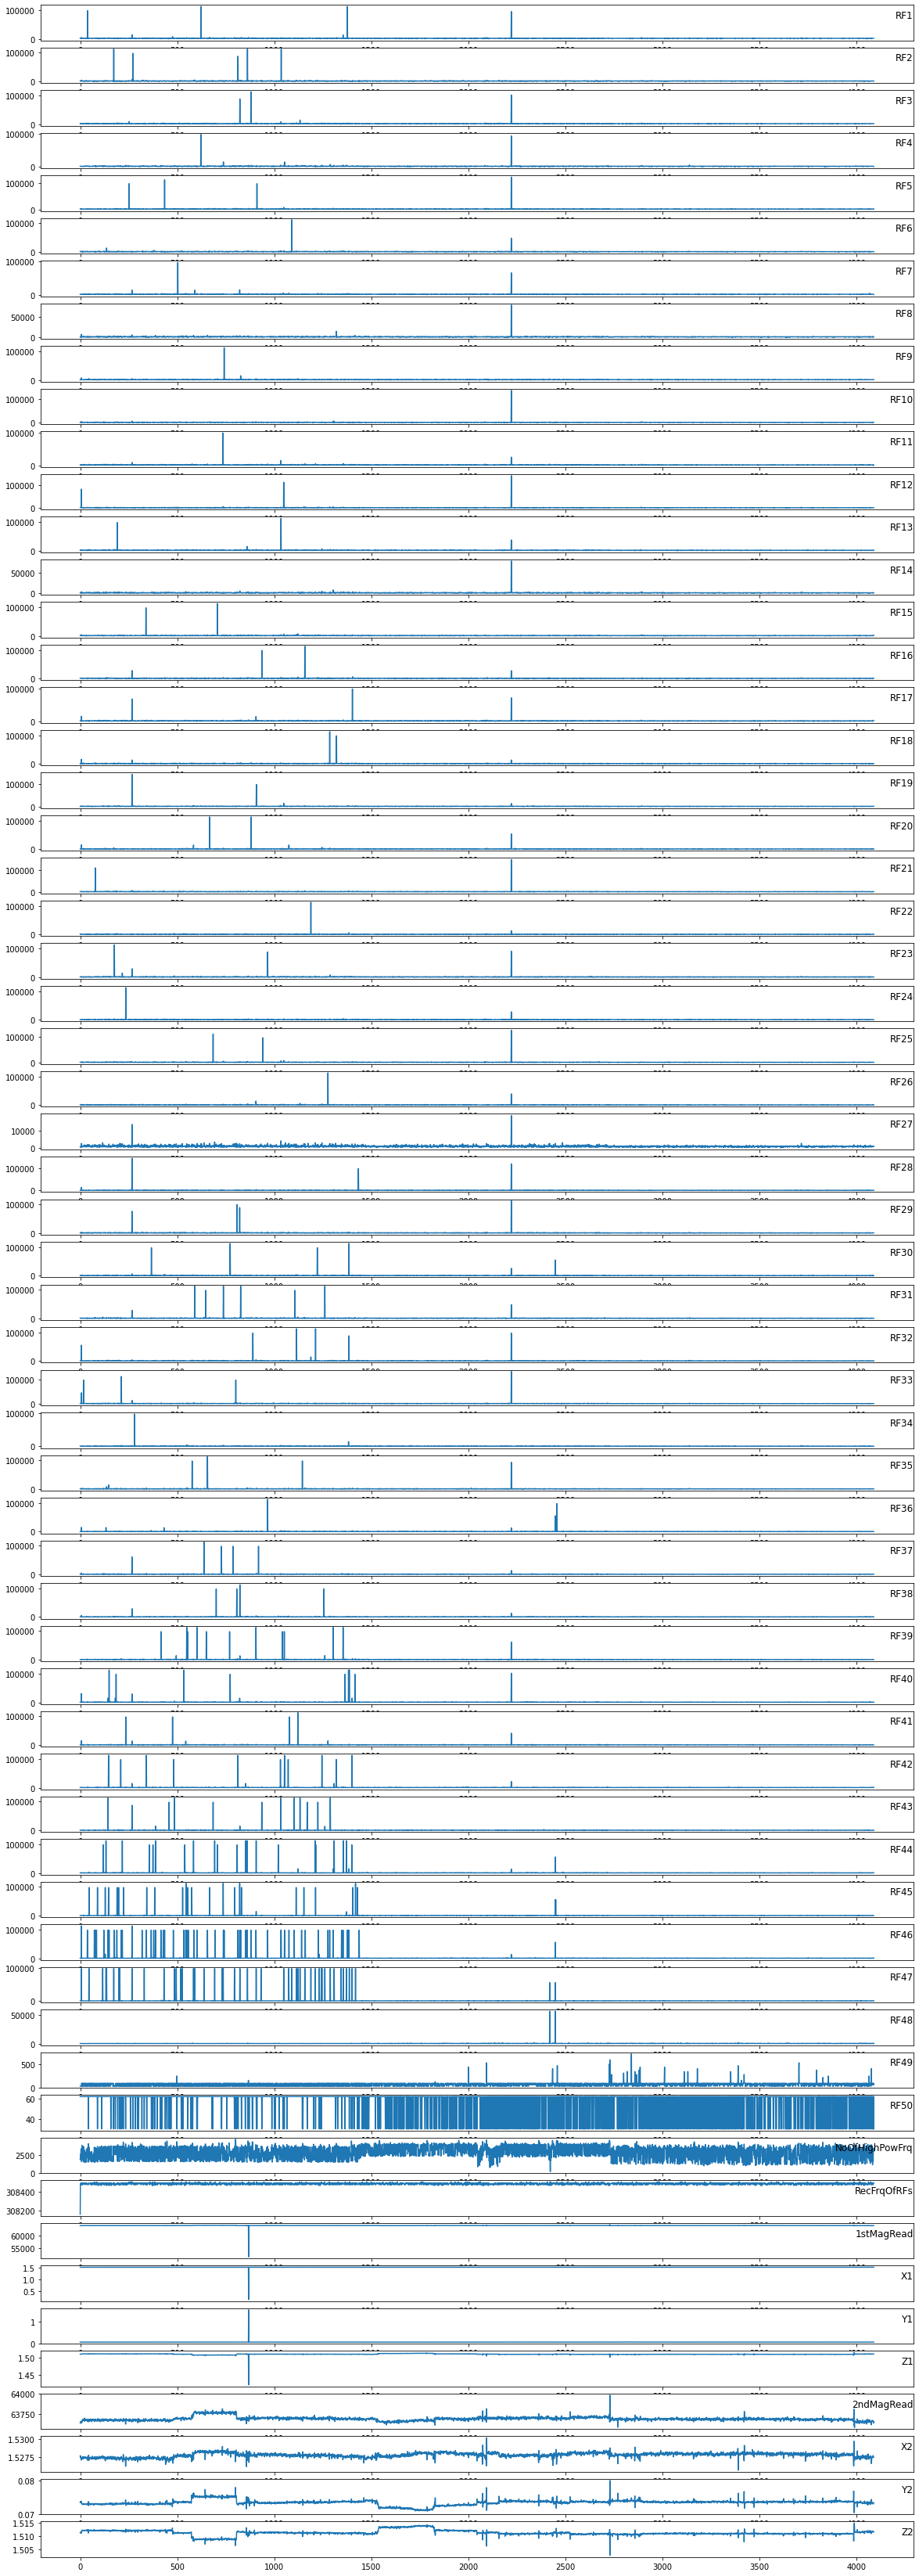

In [29]:
dataset = df_new.copy()
values = dataset.values
# specify columns to plot
groups = [x for x in range(60)]
i = 1
# plot each column
plt.figure(figsize=(20,60))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [30]:
df_new.shape

(4091, 61)

### feature scaling

In [31]:
df_new.columns

Index(['RF1', 'RF2', 'RF3', 'RF4', 'RF5', 'RF6', 'RF7', 'RF8', 'RF9', 'RF10',
       'RF11', 'RF12', 'RF13', 'RF14', 'RF15', 'RF16', 'RF17', 'RF18', 'RF19',
       'RF20', 'RF21', 'RF22', 'RF23', 'RF24', 'RF25', 'RF26', 'RF27', 'RF28',
       'RF29', 'RF30', 'RF31', 'RF32', 'RF33', 'RF34', 'RF35', 'RF36', 'RF37',
       'RF38', 'RF39', 'RF40', 'RF41', 'RF42', 'RF43', 'RF44', 'RF45', 'RF46',
       'RF47', 'RF48', 'RF49', 'RF50', 'NoOfHighPowFrq', 'RecFrqOfRFs',
       '1stMagRead', 'X1', 'Y1', 'Z1', '2ndMagRead', 'X2', 'Y2', 'Z2',
       'Category'],
      dtype='object')

In [150]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, normalize
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
dataset = df_new.copy()
# dataset = df_lda.copy()
value = dataset.values
# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = value.astype('float32')
# normalize features

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# scaled = np.hstack([train.Category.values[:, np.newaxis], scaled_])
# frame as supervised learning
reframed = series_to_supervised(scaled, 5, 1)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[np.r_[61:122]], axis=1, inplace=True)
reframed.drop(reframed.columns[np.r_[60,121,182,243,304]], axis=1, inplace=True)
# reframed.drop(reframed.columns[np.r_[1,3,5]], axis=1, inplace=True)
print(reframed.head())

   var1(t-5)  var2(t-5)  var3(t-5)  var4(t-5)  var5(t-5)  var6(t-5)  \
5   0.013962   0.015604   0.013688   0.012904   0.013286   0.015331   
6   0.013702   0.018635   0.008495   0.009452   0.012045   0.012058   
7   0.015621   0.013154   0.014525   0.013233   0.010790   0.014251   
8   0.013154   0.015620   0.010688   0.018903   0.011292   0.018909   
9   0.017265   0.014798   0.007125   0.018273   0.014053   0.015073   

   var7(t-5)  var8(t-5)  var9(t-5)  var10(t-5)  var11(t-5)  var12(t-5)  \
5   0.010071   0.009782   0.013140    0.009812    0.010386    0.012855   
6   0.018903   0.022327   0.013976    0.008451    0.012917    0.011778   
7   0.013862   0.019585   0.005755    0.001827    0.016068    0.008070   
8   0.013862   0.013709   0.009865    0.007081    0.006931    0.010905   
9   0.012917   0.017235   0.015620    0.009593    0.016383    0.015267   

   var13(t-5)  var14(t-5)  var15(t-5)  var16(t-5)  var17(t-5)  var18(t-5)  \
5    0.009582    0.014328    0.014784    0.012045  

In [151]:
# reframed.columns[[9,10,11,12,13,14,15]]
reframed.values.shape

(4086, 361)

In [152]:
# split into train and test sets
values = reframed.values
n_train_hours = 35 * 60 
df_train = values[:2497, :]
df_test = values[2497:, :]
# split into input and outputs
train_X, train_y = df_train[:,  :-1], df_train[:, -1]
test_X, test_y = df_test[:, :-1], df_test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2497, 1, 360) (2497,) (1589, 1, 360) (1589,)


In [153]:
train_X[0]

array([[1.39619270e-02, 1.56040918e-02, 1.36881657e-02, 1.29039856e-02,
        1.32860821e-02, 1.53312599e-02, 1.00710485e-02, 9.78204794e-03,
        1.31402304e-02, 9.81160533e-03, 1.03860814e-02, 1.28547270e-02,
        9.58193839e-03, 1.43276369e-02, 1.47837205e-02, 1.20452018e-02,
        1.07011590e-02, 8.48654378e-03, 3.02506168e-03, 5.47879841e-03,
        9.59166512e-03, 1.23197231e-02, 1.01291556e-02, 5.20150410e-03,
        7.24926824e-03, 7.66524533e-03, 3.00178453e-02, 5.13782818e-03,
        4.71976399e-03, 6.02264190e-03, 1.04026226e-02, 7.93878268e-03,
        6.00658869e-03, 1.22741573e-02, 7.39126187e-03, 3.01127508e-03,
        5.74905984e-03, 3.55861965e-03, 3.28485901e-03, 2.46363948e-03,
        2.18981598e-03, 1.64229446e-03, 2.73733749e-03, 1.36853359e-03,
        1.91605533e-03, 1.09474524e-03, 9.43848980e-04, 1.10457558e-03,
        0.00000000e+00, 9.97841537e-01, 3.70859444e-01, 0.00000000e+00,
        9.65528011e-01, 9.98440087e-01, 2.69334018e-03, 9.466018

In [154]:
n_train_hours

2100

In [40]:
df_train.shape

(2497, 241)

In [41]:
train_y

array([0., 0., 0., ..., 1., 0., 0.], dtype=float32)

In [42]:
from matplotlib import pyplot

In [43]:
train_X.shape, test_X.shape

((2497, 1, 240), (1591, 1, 240))

In [ ]:
y1 = np.expand_dims(train_y, -1)
y2 = np.expand_dims(val_y, -1)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-44-b28b6bdce5b9>", line 2, in <module>
    y2 = np.expand_dims(val_y, -1)
NameError: name 'val_y' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "C:\Users

In [ ]:
y_tr = y1.reshape((y1.shape[0], 1, y1.shape[1]))
y_va = y2.reshape((y2.shape[0], 1, y2.shape[1]))
y_tr.shape, y_va.shape

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-44-10b3f9ac6bb5>", line 2, in <module>
    y_va = y2.reshape((y2.shape[0], 1, y2.shape[1]))
NameError: name 'y2' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
 

from keras.callbacks import ModelCheckpoint
chk = ModelCheckpoint('best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)

In [ ]:
from keras.layers import Bidirectional,TimeDistributed,RepeatVector, GRU, RNN
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1,activation='sigmoid'))
# model.add(RepeatVector(1))
# model.add(LSTM(50, activation='relu', return_sequences=True))
# model.add(TimeDistributed(Dense(1)))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=512, verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

ERROR! Session/line number was not unique in database. History logging moved to new session 1140
Epoch 1/50
 - 0s - loss: 0.6781 - accuracy: 0.5879
Epoch 2/50
 - 0s - loss: 0.6405 - accuracy: 0.6836
Epoch 3/50
 - 0s - loss: 0.6271 - accuracy: 0.6836
Epoch 4/50
 - 0s - loss: 0.6263 - accuracy: 0.6836
Epoch 5/50
 - 0s - loss: 0.6269 - accuracy: 0.6836
Epoch 6/50
 - 0s - loss: 0.6257 - accuracy: 0.6836
Epoch 7/50
 - 0s - loss: 0.6241 - accuracy: 0.6836
Epoch 8/50
 - 0s - loss: 0.6233 - accuracy: 0.6836
Epoch 9/50
 - 0s - loss: 0.6230 - accuracy: 0.6836
Epoch 10/50
 - 0s - loss: 0.6228 - accuracy: 0.6836
Epoch 11/50
 - 0s - loss: 0.6225 - accuracy: 0.6836
Epoch 12/50
 - 0s - loss: 0.6220 - accuracy: 0.6836
Epoch 13/50
 - 0s - loss: 0.6215 - accuracy: 0.6836
Epoch 14/50
 - 0s - loss: 0.6210 - accuracy: 0.6836
Epoch 15/50
 - 0s - loss: 0.6206 - accuracy: 0.6836
Epoch 16/50
 - 0s - loss: 0.6201 - accuracy: 0.6836
Epoch 17/50
 - 0s - loss: 0.6196 - accuracy: 0.6836
Epoch 18/50
 - 0s - loss: 0.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-75-f0472cab8422>", line 14, in <module>
    pyplot.plot(history.history['loss'], label='train')
NameError: name 'pyplot' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_o

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-75-f0472cab8422>", line 14, in <module>
    pyplot.plot(history.history['loss'], label='train')
NameError: name 'pyplot' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3357, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  

In [ ]:
from keras.layers import Bidirectional,TimeDistributed,RepeatVector, RNN
# design network
model = Sequential()
model.add(RNN(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(RNN(50))
model.add(Dense(1,activation='sigmoid'))
# model.add(RepeatVector(1))
# model.add(LSTM(50, activation='relu', return_sequences=True))
# model.add(TimeDistributed(Dense(1)))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-74-ad959546354a>", line 4, in <module>
    model.add(RNN(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
  File "C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\keras\layers\recurrent.py", line 404, in __init__
    'The RNN was passed:', cell)
ValueError: ('`cell` should have a `call` method. The RNN was passed:', 50)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ValueError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

ERROR! Session/line number was not unique in database. History logging moved to new session 1080
Train on 2100 samples, validate on 397 samples
Epoch 1/50
2100/2100 - 2s - loss: 0.1113 - accuracy: 0.6948 - val_loss: 0.1235 - val_accuracy: 0.6247
Epoch 2/50
2100/2100 - 0s - loss: 0.1078 - accuracy: 0.6948 - val_loss: 0.1183 - val_accuracy: 0.6247
Epoch 3/50
2100/2100 - 0s - loss: 0.1069 - accuracy: 0.6948 - val_loss: 0.1191 - val_accuracy: 0.6247
Epoch 4/50
2100/2100 - 0s - loss: 0.1067 - accuracy: 0.6948 - val_loss: 0.1188 - val_accuracy: 0.6247
Epoch 5/50
2100/2100 - 0s - loss: 0.1064 - accuracy: 0.6948 - val_loss: 0.1188 - val_accuracy: 0.6247
Epoch 6/50
2100/2100 - 0s - loss: 0.1062 - accuracy: 0.6948 - val_loss: 0.1187 - val_accuracy: 0.6247
Epoch 7/50
2100/2100 - 0s - loss: 0.1060 - accuracy: 0.6948 - val_loss: 0.1190 - val_accuracy: 0.6247
Epoch 8/50
2100/2100 - 0s - loss: 0.1059 - accuracy: 0.6948 - val_loss: 0.1185 - val_accuracy: 0.6247
Epoch 9/50
2100/2100 - 0s - loss: 0.1054

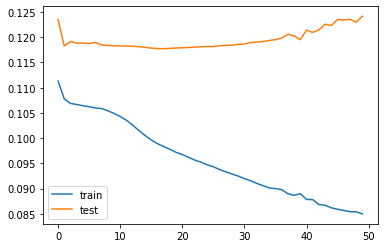

In [73]:
# from keras.layers import Bidirectional,TimeDistributed,RepeatVector
# # design network
# model = tf.keras.models.Sequential([
#   tf.keras.layers.Conv1D(filters=60, kernel_size=5,
#                       strides=1, padding="causal",
#                       activation="relu",
#                       input_shape=[train_X.shape[1], train_X.shape[2]]),
#   tf.keras.layers.LSTM(50),
# #   tf.keras.layers.LSTM(60, return_sequences=True),
# #   tf.keras.layers.Dense(30, activation="relu") ,
# #   tf.keras.layers.Dense(10, activation="relu"),
#   tf.keras.layers.Dense(1,activation='sigmoid')
# ])

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# # fit network
# history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(val_X, val_y), verbose=2, shuffle=False)
# # plot history
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
# pyplot.legend()
# pyplot.show()

In [160]:
len(train_X[0])

1

In [161]:
len(val_y)

397

In [74]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import metrics
# make a prediction
yhat = model.predict(val_X)
y_preds = model.predict_classes(val_X)

# [[221  29]
#  [ 31 118]]
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# # invert scaling for forecast
# inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]
# # invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]
# # calculate RMSE
# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)
print(accuracy_score(val_y, y_preds.ravel()))
print('')
print(confusion_matrix(val_y, abs(y_preds.ravel())))

0.5743073047858942

[[160  88]
 [ 81  68]]


In [163]:
print(metrics.classification_report(val_y, y_preds, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.70      0.83      0.76       248
           1       0.59      0.40      0.48       149

    accuracy                           0.67       397
   macro avg       0.65      0.62      0.62       397
weighted avg       0.66      0.67      0.66       397



### feature extraction from lstm

In [66]:
model = tf.keras.Sequential()
inputs = tf.keras.Input(shape=(train_X.shape[1], train_X.shape[2]))
x=tf.keras.layers.LSTM(50)(inputs)               #, dropout=0.1
o=tf.keras.layers.Dense(1,activation='softmax')(x)
model = tf.keras.Model(inputs = inputs, outputs = o)

In [68]:
feat_extractor = tf.keras.Model(inputs=inputs, outputs=x)

# Then, assuming X is a batch of input patterns:

feats_train = feat_extractor.predict(train_X)
feats_val = feat_extractor.predict(val_X)
feats_test = feat_extractor.predict(test_X)

In [60]:
feats.shape

(2100, 50)

## LDA 

In [103]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=1)

In [104]:
tr_lda = new_train.drop(columns='Category')
ts_lda = new_test.drop(columns='Category')

In [105]:
lda_train  = lda.fit_transform(X=tr_lda, y=train.Category)
lda_test = lda.transform(ts_lda)

In [106]:
lda_train.shape

(2500, 1)

In [107]:
lda_test.shape

(1591, 1)

In [108]:
np_lda = np.concatenate((lda_train,lda_test), axis=0)

In [109]:
np_lda.shape

(4091, 1)

In [110]:
np_lda.ravel()

array([-0.47435466, -0.58587594, -0.2006715 , ..., -0.55245773,
        0.47238681, -0.17655679])

In [111]:
dt_lda = pd.DataFrame()
df_lda['lda'] = np_lda.ravel()
df_lda['Category'] = df_new['Category'].values

ERROR! Session/line number was not unique in database. History logging moved to new session 1051


In [83]:
x_train = train_X.reshape(train_X.shape[0],train_X.shape[2])
y_train = train_y
# x_val = val_X.reshape(val_X.shape[0],val_X.shape[2])
# y_val = val_y

ERROR! Session/line number was not unique in database. History logging moved to new session 1143


In [84]:
x_test = test_X.reshape(test_X.shape[0],test_X.shape[2])

In [69]:
x_train = feats_train
x_val = feats_val
x_test = feats_test

In [167]:
x_train.shape, x_val.shape

((2100, 4), (397, 4))

In [168]:
from gplearn.genetic import SymbolicClassifier

sbc = SymbolicClassifier()
sbc.fit(x_train, y_train)
pred_sbc = sbc.predict(x_val)
confusion_matrix(y_val, pred_sbc)

array([[237,  11],
       [124,  25]], dtype=int64)

In [55]:
from gplearn.genetic import SymbolicClassifier

sbc = SymbolicClassifier()
sbc.fit(x_train, y_train)

SymbolicClassifier()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-48-806b98fba4f6>", line 5, in <module>
    ax.plot(gpc.predict_proba(x_val)[:,1], marker='o', markersize=3, linestyle='-', label='Index')
NameError: name 'gpc' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframe

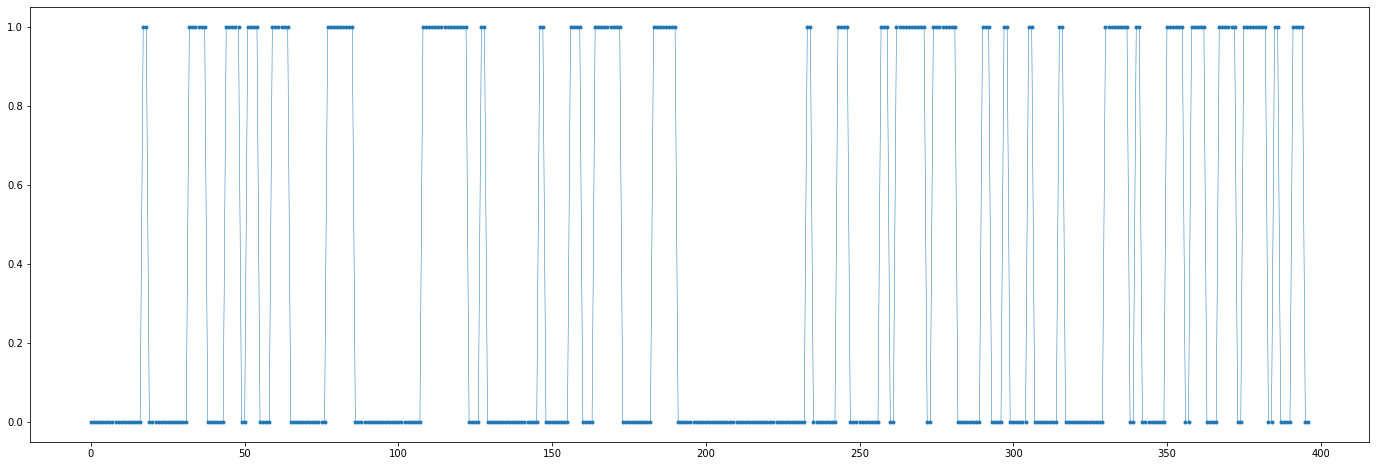

In [ ]:
import matplotlib.pyplot as plt
y = y_val
fig, ax = plt.subplots(figsize=(24, 8))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Class')
ax.plot(gpc.predict_proba(x_val)[:,1], marker='o', markersize=3, linestyle='-', label='Index')
ax.set_ylabel('Orders')
ax.legend();

In [86]:
train_X.shape

(2100, 1, 240)

In [53]:
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.gaussian_process.kernels import RBF

# kernel = 2.0 * RBF(1.0)
# gpc = GaussianProcessClassifier(kernel=kernel, random_state=0).fit(x_train, y_train)
# gpc.score(x_train, y_train)
# pred_gpc = gpc.predict(x_val)
# confusion_matrix(y_val, pred_gpc)

array([[185,  63],
       [ 89,  60]], dtype=int64)

In [169]:
from sklearn.gaussian_process import GaussianProcessClassifier

gpc = GaussianProcessClassifier()
gpc.fit(x_train, y_train)
pred_gpc = gpc.predict(x_val)
confusion_matrix(y_val, pred_gpc)

array([[159,  89],
       [ 64,  85]], dtype=int64)

In [156]:
from xgboost import XGBClassifier
XGB = XGBClassifier(eval_metric='mlogloss')
XGB.fit(x_train, y_train)
# cross_val(XGB, x_train, y_train)
# pred_xgb = XGB.predict(x_val)
# confusion_matrix(y_val, pred_xgb)
#  

C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [ ]:
from sklearn.svm import SVC

SVCl = SVC(kernel = 'rbf', random_state = 0, probability=True)
SVCl.fit(x_train, y_train)
pred_SVCl = SVCl.predict(x_val)
print(confusion_matrix(y_val, pred_SVCl))
print(adjust_threshold(SVCl, x_val, y_val))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



[[202  46]
 [ 84  65]]
Traceback (most recent call last):
  File "C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-171-469a3fff41df>", line 7, in <module>
    print(adjust_threshold(SVCl, x_val, y_val))
NameError: name 'adjust_threshold' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_

In [171]:
pred_prob_scv = SVCl.predict_proba(x_test)

pred_scv_test = (pred_prob_scv[:,1] >= 0.44999999999999996).astype('int')

ERROR! Session/line number was not unique in database. History logging moved to new session 1057


In [172]:

from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(x_train, y_train)


# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.695 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.695 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.695 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.695 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.693 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.695 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.695 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.695 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.695 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.693 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.695 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

In [213]:
grid_predictions = grid.best_estimator_.predict(x_val)
print(confusion_matrix(y_val, grid_predictions))
# print classification report
print(classification_report(y_val, grid_predictions))

[[179  69]
 [ 88  61]]
              precision    recall  f1-score   support

         0.0       0.67      0.72      0.70       248
         1.0       0.47      0.41      0.44       149

    accuracy                           0.60       397
   macro avg       0.57      0.57      0.57       397
weighted avg       0.59      0.60      0.60       397



In [214]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(random_state = 0,warm_start=True,solver='saga')
LR.fit(x_train, y_train)
# cross_val(LR, x_train, y_train)
pred_lr = LR.predict(x_val)
print(confusion_matrix(y_val, pred_lr))
print(adjust_threshold(LR, x_val, y_val))

[[159  89]
 [ 65  84]]

---Optimum Threshold --- 0.6 --Accuracy_Score-- 0.6700251889168766
              precision    recall  f1-score   support

           0       0.67      0.94      0.78       248
           1       0.70      0.21      0.33       149

    accuracy                           0.67       397
   macro avg       0.68      0.58      0.55       397
weighted avg       0.68      0.67      0.61       397


Confusion Matrix:
[[234  14]
 [117  32]]
None


In [173]:
lr_test = LR.predict(x_test)

ERROR! Session/line number was not unique in database. History logging moved to new session 1059


In [125]:
pred_prob_lr= SVCl.predict_proba(x_test)

pred_lr_test = (pred_prob_scv[:,1] >= 0.6).astype('int')

In [216]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

parameters = {
    'C': np.linspace(1, 10, 10), "penalty":["l1","l2"]
             }
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, cv=5, verbose=5, n_jobs=-1)
clf.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan 0.73571429        nan 0.73095238        nan 0.72952381
        nan 0.72857143        nan 0.72809524        nan 0.72809524
        nan 0.72857143        nan 0.72714286        nan 0.72857143
        nan 0.72904762]
  category=UserWarning


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
                         'penalty': ['l1', 'l2']},
             verbose=5)

In [217]:
clf.best_params_

{'C': 1.0, 'penalty': 'l2'}

In [218]:
lr1 = LogisticRegression(C=clf.best_params_.get('C'),penalty='l2', verbose=5, solver='liblinear')
lr1.fit(x_train, y_train)

pred_lr = LR.predict(x_val)
confusion_matrix(y_val, pred_lr)
adjust_threshold(LR, x_val, y_val)

[LibLinear]
---Optimum Threshold --- 0.6 --Accuracy_Score-- 0.6700251889168766
              precision    recall  f1-score   support

           0       0.67      0.94      0.78       248
           1       0.70      0.21      0.33       149

    accuracy                           0.67       397
   macro avg       0.68      0.58      0.55       397
weighted avg       0.68      0.67      0.61       397


Confusion Matrix:
[[234  14]
 [117  32]]


In [219]:
from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB()
GNB.fit(x_train, y_train)
pred_GNB = GNB.predict(x_val)
confusion_matrix(y_val, pred_GNB)

array([[ 86, 162],
       [ 31, 118]], dtype=int64)

In [220]:
from sklearn.neighbors import KNeighborsClassifier
KNC = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
KNC.fit(x_train, y_train)
pred_GNB = KNC.predict(x_val)
confusion_matrix(y_val, pred_GNB)

array([[169,  79],
       [ 87,  62]], dtype=int64)

In [221]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(x_train, y_train)
pred_GNB = DT.predict(x_val)
confusion_matrix(y_val, pred_GNB)

array([[164,  84],
       [ 76,  73]], dtype=int64)

In [155]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(criterion = "gini", random_state = 0, n_estimators=1000)
RFC.fit(x_train, y_train)
# pred_GNB = RFC.predict(x_val)
# confusion_matrix(y_val, pred_GNB)

RandomForestClassifier(n_estimators=1000, random_state=0)

In [108]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 500, 1000]
}

In [109]:
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [110]:
# Fit the grid search to the data
grid_search.fit(x_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


{'bootstrap': True,
 'max_depth': 90,
 'max_features': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 300}

In [111]:
best_grid = grid_search.best_estimator_

In [112]:
best_grid.fit(x_train, y_train)
# pred_rfg = best_grid.predict(x_val)
# confusion_matrix(y_val, pred_rfg)

ERROR! Session/line number was not unique in database. History logging moved to new session 1108


RandomForestClassifier(max_depth=90, max_features=2, min_samples_leaf=3,
                       min_samples_split=10, n_estimators=300)

In [228]:
from sklearn.ensemble import AdaBoostClassifier
ABC = AdaBoostClassifier()
ABC.fit(x_train, y_train)
pred_GNB = ABC.predict(x_val)
confusion_matrix(y_val, pred_GNB)

array([[148, 100],
       [ 71,  78]], dtype=int64)

In [131]:
from sklearn.ensemble import AdaBoostClassifier
ABC = AdaBoostClassifier()
ABC.fit(x_train, y_train)

AdaBoostClassifier()

In [180]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier()
lgb.fit(x_train,y_train)
pred_GNB = lgb.predict(x_val)
confusion_matrix(y_val, pred_GNB)

array([[176,  72],
       [ 92,  57]], dtype=int64)

In [ ]:
from sklearn.neural_network import MLPClassifier
snn_classifier = MLPClassifier()
snn_classifier.fit(x_train, y_train)

pred_GNB = snn_classifier.predict(x_val)
confusion_matrix(y_val, pred_GNB)

ERROR! Session/line number was not unique in database. History logging moved to new session 1114


C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-173-6ec05e92aac4>", line 5, in <module>
    pred_GNB = snn_classifier.predict(x_val)
NameError: name 'x_val' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  Fil

In [182]:
dnn_classifier = MLPClassifier(hidden_layer_sizes = [100]*5)
dnn_classifier.fit(x_train, y_train)

pred_GNB = dnn_classifier.predict(x_val)
confusion_matrix(y_val, pred_GNB)

array([[128, 120],
       [ 44, 105]], dtype=int64)

In [183]:
from sklearn.multiclass import OneVsRestClassifier
dnns_classifier = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes = [100]*5))
dnns_classifier.fit(x_train, y_train)

pred_GNB = dnns_classifier.predict(x_val)
confusion_matrix(y_val, pred_GNB)

array([[167,  81],
       [ 65,  84]], dtype=int64)

In [173]:
from sklearn.multiclass import OneVsRestClassifier
dnns_classifier = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes = [100]*5))
dnns_classifier.fit(x_train, y_train)

ERROR! Session/line number was not unique in database. History logging moved to new session 1115


OneVsRestClassifier(estimator=MLPClassifier(hidden_layer_sizes=[100, 100, 100,
                                                                100, 100]))

In [85]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
n_estimators = [10,30,50,70,80,150,160, 170,175,180,185];
cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=15)

parameters = {'n_estimators':n_estimators,
              
        }
grid = GridSearchCV(BaggingClassifier(base_estimator= None, ## If None, then the base estimator is a decision tree.
                                      bootstrap_features=False),
                                 param_grid=parameters,
                                 cv=cv,
                                 n_jobs = -1)
grid.fit(x_train, y_train) 

ERROR! Session/line number was not unique in database. History logging moved to new session 1146


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=15, test_size=0.3,
            train_size=None),
             estimator=BaggingClassifier(), n_jobs=-1,
             param_grid={'n_estimators': [10, 30, 50, 70, 80, 150, 160, 170,
                                          175, 180, 185]})

In [86]:
print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

0.7054666666666667
{'n_estimators': 175}
BaggingClassifier(n_estimators=175)


In [87]:
bagging_grid = grid.best_estimator_
bagging_grid.score(x_train, y_train)

1.0

In [229]:
pred_bag = bagging_grid.predict(x_val)
confusion_matrix(y_val, pred_bag)

array([[179,  69],
       [ 88,  61]], dtype=int64)

### catboost

In [ ]:
# Define the categorical features for the CatBoost model
cat_features = np.where(x_train.dtypes != np.float)[0]
cat_features

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-112-b160049fcd79>", line 2, in <module>
    cat_features = np.where(x_train.dtypes != np.float)[0]
AttributeError: 'numpy.ndarray' object has no attribute 'dtypes'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb,

In [112]:
cat_features = []

ERROR! Session/line number was not unique in database. History logging moved to new session 1149


In [113]:
# Use the CatBoost Pool() function to pool together the training data and categorical feature labels
from catboost import Pool

train_pool = Pool(x_train,
             y_train,
             cat_features)

In [114]:
from catboost import CatBoostClassifier, cv

catboost_model = CatBoostClassifier(iterations=1000,
                                  custom_loss=['Accuracy'],
                                  loss_function='Logloss',
                                   #task_type="GPU",
                                    #devices='0'
                                   )

# Fit CatBoost model
catboost_model.fit(train_pool,
                   plot=True)

# CatBoost accuracy
acc_catboost = round(catboost_model.score(x_train, y_train) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.015228
0:	learn: 0.6897523	total: 182ms	remaining: 3m 1s
1:	learn: 0.6867138	total: 198ms	remaining: 1m 39s
2:	learn: 0.6837489	total: 214ms	remaining: 1m 11s
3:	learn: 0.6810658	total: 230ms	remaining: 57.3s
4:	learn: 0.6785044	total: 247ms	remaining: 49.1s
5:	learn: 0.6758303	total: 263ms	remaining: 43.6s
6:	learn: 0.6734070	total: 279ms	remaining: 39.6s
7:	learn: 0.6707773	total: 296ms	remaining: 36.6s
8:	learn: 0.6684976	total: 313ms	remaining: 34.4s
9:	learn: 0.6659524	total: 328ms	remaining: 32.5s
10:	learn: 0.6638035	total: 344ms	remaining: 31s
11:	learn: 0.6615400	total: 361ms	remaining: 29.7s
12:	learn: 0.6594411	total: 377ms	remaining: 28.6s
13:	learn: 0.6570172	total: 393ms	remaining: 27.7s
14:	learn: 0.6546751	total: 410ms	remaining: 26.9s
15:	learn: 0.6524878	total: 426ms	remaining: 26.2s
16:	learn: 0.6503127	total: 443ms	remaining: 25.6s
17:	learn: 0.6484692	total: 459ms	remaining: 25s
18:	learn: 0.6463385	total: 475ms	remaining: 24.5s
19:	learn: 0.

### CatBoost Cross Validation

In [246]:
import time, datetime
# How long will this take?
start_time = time.time()

# Set params for cross-validation as same as initial model
cv_params = catboost_model.get_params()

# Run the cross-validation for 10-folds (same as the other models)
cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=True)

# How long did it take?
catboost_time = (time.time() - start_time)

# CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6857195	test: 0.6870980	best: 0.6870980 (0)	total: 559ms	remaining: 9m 18s
1:	learn: 0.6789369	test: 0.6815272	best: 0.6815272 (1)	total: 918ms	remaining: 7m 37s
2:	learn: 0.6731563	test: 0.6763636	best: 0.6763636 (2)	total: 1.32s	remaining: 7m 19s
3:	learn: 0.6676997	test: 0.6718337	best: 0.6718337 (3)	total: 1.74s	remaining: 7m 13s
4:	learn: 0.6626447	test: 0.6674077	best: 0.6674077 (4)	total: 2.14s	remaining: 7m 6s
5:	learn: 0.6577922	test: 0.6633723	best: 0.6633723 (5)	total: 2.66s	remaining: 7m 21s
6:	learn: 0.6525078	test: 0.6589065	best: 0.6589065 (6)	total: 3.09s	remaining: 7m 18s
7:	learn: 0.6475457	test: 0.6547637	best: 0.6547637 (7)	total: 3.5s	remaining: 7m 14s
8:	learn: 0.6433420	test: 0.6510483	best: 0.6510483 (8)	total: 3.93s	remaining: 7m 12s
9:	learn: 0.6391647	test: 0.6473961	best: 0.6473961 (9)	total: 4.41s	remaining: 7m 16s
10:	learn: 0.6350190	test: 0.6439234	best: 0.6439234 (10)	total: 4.84s	remaining: 7m 15s
11:	learn: 0.6311873	test: 0.6408497	best: 

In [247]:
# Print out the CatBoost model metrics
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy cross-validation 10-Fold: {}".format(acc_cv_catboost))
print("Running Time: {}".format(datetime.timedelta(seconds=catboost_time)))

---CatBoost Metrics---
Accuracy: 97.9
Accuracy cross-validation 10-Fold: 71.95
Running Time: 0:09:03.141810


In [248]:
catboost_results = catboost_model.predict(x_val)

In [249]:
confusion_matrix(y_val, catboost_results)

array([[189,  59],
       [ 99,  50]], dtype=int64)

In [187]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)

def cross_val(Classifier, x_train, y_train):
    accuracies = cross_val_score(estimator=Classifier, X=x_train, y=y_train, cv=skf)
#     print(accuracies)
    print("Accuracy: {:.2f} %".format(accuracies.mean()*100))

In [188]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

def conf_mat(model, x_val, y_val):
    y_pred = model.predict(x_val)

    # --classification report --
    print('\nClassification Report:')
    print(metrics.classification_report(y_val, y_pred, labels=[0,1]))

    # --confusion matrix
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_val, y_pred))
#   print('---------------------------------------------------------------------------------------')

In [189]:
# from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

def adjust_threshold(model, x_val, y_val):
    step_factor = 0.05 
    threshold_value = 0.2
    roc_score=0
    predicted_proba = model.predict_proba(x_val) #probability of prediction
    print('')
    while threshold_value <=0.8: #continue to check best threshold upto probability 0.8
        temp_thresh = threshold_value
        predicted = (predicted_proba [:,1] >= temp_thresh).astype('int') #change the class boundary for prediction
#         print('Threshold',temp_thresh,'--',accuracy_score(y_val, predicted))
        if roc_score<accuracy_score(y_val, predicted): #store the threshold for best classification
            roc_score = accuracy_score(y_val, predicted)
            thrsh_score = threshold_value
        threshold_value = threshold_value + step_factor
    print('---Optimum Threshold ---',thrsh_score,'--Accuracy_Score--',roc_score)
    
    predicted = (predicted_proba [:,1] >= thrsh_score).astype('int')
    print(metrics.classification_report(y_val, predicted, labels=[0,1]))
    # --confusion matrix
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_val, predicted))

In [190]:
cross_val(bagging_grid, x_train, y_train)

Accuracy: 69.95 %


In [191]:
conf_mat(bagging_grid, x_val, y_val)


Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.72      0.70       248
           1       0.47      0.41      0.44       149

    accuracy                           0.60       397
   macro avg       0.57      0.57      0.57       397
weighted avg       0.59      0.60      0.60       397


Confusion Matrix:
[[179  69]
 [ 88  61]]


In [192]:
from sklearn.svm import SVC
print('SVC-linear Classifier: \n')
SVCl = SVC(kernel = 'rbf', random_state = 0, probability=True)
SVCl.fit(x_train, y_train)
pred_GNB = SVCl.predict(x_val)
confusion_matrix(y_val, pred_GNB)

SVC-linear Classifier: 



array([[202,  46],
       [ 84,  65]], dtype=int64)

In [194]:
import keras

ann = keras.Sequential([
        keras.layers.Dense(26, activation='relu'),
        keras.layers.Dense(15, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])   

ann.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_val, y_val), verbose=2, shuffle=False)

Train on 2100 samples, validate on 397 samples
Epoch 1/50
 - 0s - loss: 0.6918 - accuracy: 0.5224 - val_loss: 0.6812 - val_accuracy: 0.6247
Epoch 2/50
 - 0s - loss: 0.6658 - accuracy: 0.6948 - val_loss: 0.6713 - val_accuracy: 0.6247
Epoch 3/50
 - 0s - loss: 0.6493 - accuracy: 0.6948 - val_loss: 0.6667 - val_accuracy: 0.6247
Epoch 4/50
 - 0s - loss: 0.6367 - accuracy: 0.6948 - val_loss: 0.6689 - val_accuracy: 0.6247
Epoch 5/50
 - 0s - loss: 0.6310 - accuracy: 0.6948 - val_loss: 0.6727 - val_accuracy: 0.6247
Epoch 6/50
 - 0s - loss: 0.6287 - accuracy: 0.6948 - val_loss: 0.6744 - val_accuracy: 0.6247
Epoch 7/50
 - 0s - loss: 0.6275 - accuracy: 0.6948 - val_loss: 0.6746 - val_accuracy: 0.6247
Epoch 8/50
 - 0s - loss: 0.6266 - accuracy: 0.6948 - val_loss: 0.6742 - val_accuracy: 0.6247
Epoch 9/50
 - 0s - loss: 0.6257 - accuracy: 0.6948 - val_loss: 0.6734 - val_accuracy: 0.6247
Epoch 10/50
 - 0s - loss: 0.6248 - accuracy: 0.6948 - val_loss: 0.6725 - val_accuracy: 0.6247
Epoch 11/50
 - 0s - lo

In [211]:
ann_pred = ann.predict_classes(x_val)

In [212]:
confusion_matrix(y_val, ann_pred)

array([[142, 106],
       [ 52,  97]], dtype=int64)

In [60]:
# from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

def adjust_threshold(predicted_proba, y_val):
    step_factor = 0.05 
    threshold_value = 0.2
    roc_score=0
    predicted_proba = np.ravel(predicted_proba) #probability of prediction
    print('')
    while threshold_value <=0.8: #continue to check best threshold upto probability 0.8
        temp_thresh = threshold_value
        predicted = (predicted_proba >= temp_thresh).astype('int') #change the class boundary for prediction
#         print('Threshold',temp_thresh,'--',accuracy_score(y_val, predicted))
        if roc_score<accuracy_score(y_val, predicted): #store the threshold for best classification
            roc_score = accuracy_score(y_val, predicted)
            thrsh_score = threshold_value
        threshold_value = threshold_value + step_factor
    print('---Optimum Threshold ---',thrsh_score,'--Accuracy_Score--',roc_score)
    
    predicted = (predicted_proba >= thrsh_score).astype('int')
    print(metrics.classification_report(y_val, predicted, labels=[0,1]))
    # --confusion matrix
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_val, predicted))

In [61]:
np.ravel(yhat).shape

(397,)

In [62]:
adjust_threshold(yhat, val_y)


---Optimum Threshold --- 0.5499999999999999 --Accuracy_Score-- 0.6448362720403022
              precision    recall  f1-score   support

           0       0.64      0.97      0.77       248
           1       0.67      0.11      0.18       149

    accuracy                           0.64       397
   macro avg       0.66      0.54      0.48       397
weighted avg       0.65      0.64      0.55       397


Confusion Matrix:
[[240   8]
 [133  16]]


In [76]:
rfc_pred = RFC.predict(x_test)

In [44]:
test_pred =  model.predict(test_X)
np.round(test_pred)

ERROR! Session/line number was not unique in database. History logging moved to new session 1105


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [45]:
model.predict_classes(test_X).ravel()

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
predicted_result = model.predict_classes(test_X).ravel()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-88-2589817b8844>", line 1, in <module>
    predicted_result = bagging_grid.predict_classes(test_X).ravel()
AttributeError: 'BaggingClassifier' object has no attribute 'predict_classes'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixe

In [66]:
from sklearn.cluster import DBSCAN

DBSCAN = DBSCAN()
DBSCAN.fit(x_train, y_train)

DBSCAN()

In [115]:
# (DBSCAN.fit_predict(x_test)>6).astype(int)

array([0, 0, 0, ..., 1, 0, 0])

In [131]:
predicted_result = (DBSCAN.fit_predict(x_test)>7).astype(int)

In [156]:
predicted_result = RFC.predict(x_test).astype(int)

In [157]:
o_test = pd.read_csv('CSE_DSIntro1_TEST.csv')

In [158]:
submission = pd.DataFrame()
submission['Id'] = o_test['Id']
# submission['Category'] = pred_scv_test
# submission['Category'] = pred_lr_test
# submission['Category'] = LR.predict(x_test).astype(int)
submission['Category'] = predicted_result

In [159]:
submission.head()

,Id,Category
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [160]:
submission.shape

(1591, 2)

In [161]:
submission.Category.value_counts()

0    1474
1     117
Name: Category, dtype: int64

In [162]:
submission.iloc[:1001,:].Category.value_counts()

0    948
1     53
Name: Category, dtype: int64

In [165]:
submission.iloc[1001:,:].Category.value_counts()

0    526
1     64
Name: Category, dtype: int64

In [166]:
submission.Category.value_counts()[1]/(submission.Category.value_counts()[0]+submission.Category.value_counts()[1])

0.07353865493400377

In [167]:
submission.dtypes

Id          int64
Category    int32
dtype: object

In [168]:
submission.to_csv('F:/predictions.csv', index=False)

In [169]:
sub = pd.read_csv('F:/predictions.csv')
sub.head()

,Id,Category
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [170]:
sub.Category.value_counts()

0    1474
1     117
Name: Category, dtype: int64

In [171]:
print(sub.iloc[:1001,:]['Category'].value_counts())
print(sub.iloc[1001:,:]['Category'].value_counts())

0    948
1     53
Name: Category, dtype: int64
0    526
1     64
Name: Category, dtype: int64


In [146]:
prin(ddw

SyntaxError: unexpected EOF while parsing (<ipython-input-146-305f708a8d86>, line 1)

In [ ]:
new_train.head()

In [ ]:
values.shape

In [ ]:
np.reshape(new_train.iloc[2499].values, (1, -1)).shape

In [ ]:
last_col_scalled = scaler.transform(np.reshape(new_test.iloc[0].values, (1, -1)))
last_col_scalled.shape

In [ ]:
tar = np.reshape([train['Category'].iloc[2499]], (1, -1)).astype('float32')

In [ ]:
tar.shape

In [ ]:
ex_test = np.concatenate((tar, last_col_scalled),axis=1)
print(ex_test.shape)
ex_test

In [ ]:
ex_test_3 = np.reshape(ex_test, (ex_test.shape[0], 1, ex_test.shape[1]))
ex_test_3.shape

In [ ]:
model.predict(ex_test_3)

In [ ]:
tar_test = np.array([0.5 for x in range(1591)])
tar_test.shape

In [ ]:
# load dataset
test_dataset = new_test.copy()
value_test = test_dataset.values
# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values_test = value_test.astype('float32')
# normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler.transform(values_test)
scaled = np.hstack([tar_test[:, np.newaxis], scaled_test])

In [ ]:
scaled.shape

In [ ]:
test_3 = np.reshape(scaled, (scaled[0], 1, scaled[1]))
test_3.shape